In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

import tensorflow as tf
keras = tf.keras

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM

In [2]:
hal_data = pd.read_csv('/kaggle/input/nse-defence-stocks-india/HAL.NS(1).csv', index_col='Date')

In [3]:
hal_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-02,1127.699951,1155.000000,1100.050049,1102.849976,939.665161,463619
2018-04-09,1100.500000,1150.000000,1080.099976,1123.050049,956.876221,352724
2018-04-16,1125.000000,1164.000000,1118.000000,1125.550049,959.006348,324581
2018-04-23,1132.000000,1149.000000,1122.000000,1125.800049,959.219238,137822
2018-04-30,1134.400024,1134.400024,1089.199951,1093.550049,931.741211,68802


<AxesSubplot:xlabel='Date'>

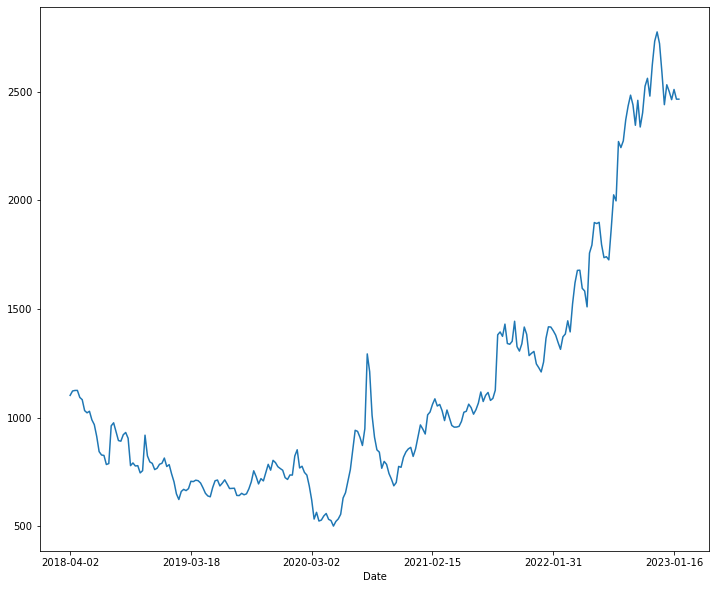

In [4]:
hal_data['Close'].plot(figsize=(12,10))

In [5]:
hal_data = hal_data.dropna()

In [6]:
scaled_hal_data = scaler.fit_transform(hal_data)

In [7]:
scaled_hal_data.shape

(253, 6)

In [8]:
look_back = 6

hal_data_generator = TimeseriesGenerator(scaled_hal_data, scaled_hal_data, length=look_back, batch_size=1)

In [9]:
hal_model = Sequential()

n_features = scaled_hal_data.shape[1]

hal_model.add(LSTM(128, activation='relu', return_sequences=True , input_shape=(look_back,n_features)))
hal_model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(look_back,n_features)))
hal_model.add(LSTM(512, activation='relu',  input_shape=(look_back,n_features)))

hal_model.add(Dense(n_features))

hal_model.compile(optimizer='adam', loss='mse')

2023-02-04 03:41:49.678200: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
hal_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 128)            69120     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 256)            394240    
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1574912   
_________________________________________________________________
dense (Dense)                (None, 6)                 3078      
Total params: 2,041,350
Trainable params: 2,041,350
Non-trainable params: 0
_________________________________________________________________


In [11]:
hal_model.fit(hal_data_generator, epochs=500)

2023-02-04 03:42:17.861769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
247/247 [==============================] - 12s 29ms/step - loss: 0.0296
Epoch 2/500
247/247 [==============================] - 7s 30ms/step - loss: 0.0089
Epoch 3/500
247/247 [==============================] - 7s 30ms/step - loss: 0.0080
Epoch 4/500
247/247 [==============================] - 7s 29ms/step - loss: 0.0079
Epoch 5/500
247/247 [==============================] - 7s 29ms/step - loss: 0.0074
Epoch 6/500
247/247 [==============================] - 7s 29ms/step - loss: 0.0067
Epoch 7/500
247/247 [==============================] - 7s 29ms/step - loss: 0.0060
Epoch 8/500
247/247 [==============================] - 8s 31ms/step - loss: 0.0067
Epoch 9/500
247/247 [==============================] - 7s 30ms/step - loss: 0.0060
Epoch 10/500
247/247 [==============================] - 7s 30ms/step - loss: 0.0059
Epoch 11/500
247/247 [==============================] - 8s 33ms/step - loss: 0.0051
Epoch 12/500
247/247 [==============================] - 7s 29ms/step - loss: 0.0066


In [12]:
hal_model.save('/kaggle/working/hal_model.h5')

In [13]:
# for exporting important objects of model
import joblib

# create PKL files of important objects required for project
# these are required for prediction of future stock prices and also for the flask app
joblib.dump(scaler, "/kaggle/working/scaler.pkl")
joblib.dump(scaled_hal_data, "/kaggle/working/scaled_hal_data.pkl")
joblib.dump(look_back, "/kaggle/working/look_back.pkl")

['/kaggle/working/look_back.pkl']

<AxesSubplot:>

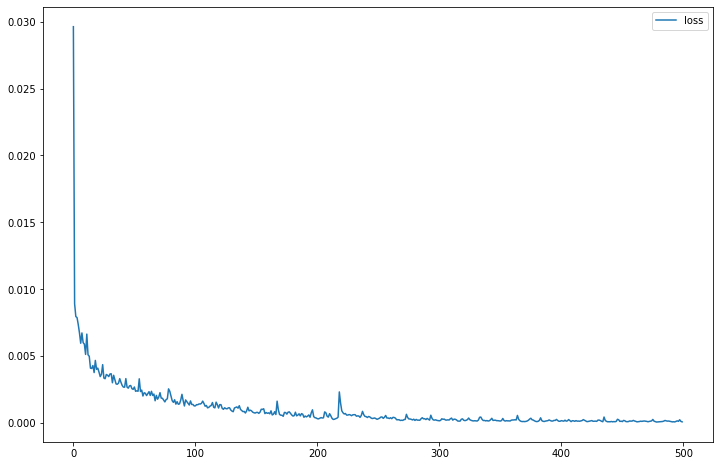

In [14]:
hal_loss = pd.DataFrame(hal_model.history.history)
hal_loss.plot(figsize=(12,8))